# Today candlestick color - Analytics & Predicts

### Import Library

In [37]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [38]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [39]:
tmp_data = dataset.copy()

In [40]:
tmp_data["ma_line"] = tmp_data["Close"].rolling(20).mean()
tmp_data['above_ma'] = tmp_data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
tmp_data['below_ma'] = tmp_data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
tmp_data['total_above_ma'] = tmp_data['above_ma'].rolling(150).sum()
tmp_data['total_below_ma'] = tmp_data['below_ma'].rolling(150).sum()
tmp_data['trend_diff'] = tmp_data['total_above_ma'] - tmp_data['total_below_ma']
tmp_data["EMA"] = ta.ema(tmp_data["Close"], length=20)

In [41]:
def bar9h(tick):
    tick=tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
def bar14h(tick):
    tick=tick[(tick.index.hour == 14) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]
tmp_data['Close_9h'] = tmp_data['Close']
tmp_data['Close_14h'] = tmp_data['Close']
day_data = tmp_data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Close_9h': bar9h,
        'Close_14h': bar14h,
        'trend_diff': bar9h,
        'EMA': bar9h
    })
day_data.dropna(subset=['Close'], inplace=True)
day_data['Close_Yesterday'] = day_data['Close'].shift(1)
day_data['Close_14h_Yesterday'] = day_data['Close_14h'].shift(1)
day_data['High_Yesterday'] = day_data['High'].shift(1)
day_data['Low_Yesterday'] = day_data['Low'].shift(1)

In [42]:
day_data['rate_overnight_14h'] = (day_data['Close_9h'] - day_data['Close_Yesterday']) / (day_data['Close_Yesterday'] - day_data['Close_14h_Yesterday'])
day_data['rate_overnight_hl'] = (day_data['Close_9h'] - day_data['Close_Yesterday']) / (day_data['High_Yesterday'] - day_data['Low_Yesterday'])
day_data['rate_EMA_9hClose'] = 1000*(day_data['Close_9h'] - day_data['EMA']) / day_data['EMA']

In [43]:
day_data['cs_color_group'] = day_data.apply(lambda r: 0 if r['Close'] == r['Open'] else (1 if r['Close'] > r['Open'] else -1), axis=1)
day_data['body_rate'] = day_data.apply(lambda r: (r['Close'] - r['Open']) / (r['High'] - r['Low']), axis=1)

In [44]:
white_group = day_data[day_data.cs_color_group==1]
black_group = day_data[day_data.cs_color_group==-1]
doji_group = day_data[day_data.cs_color_group==0]

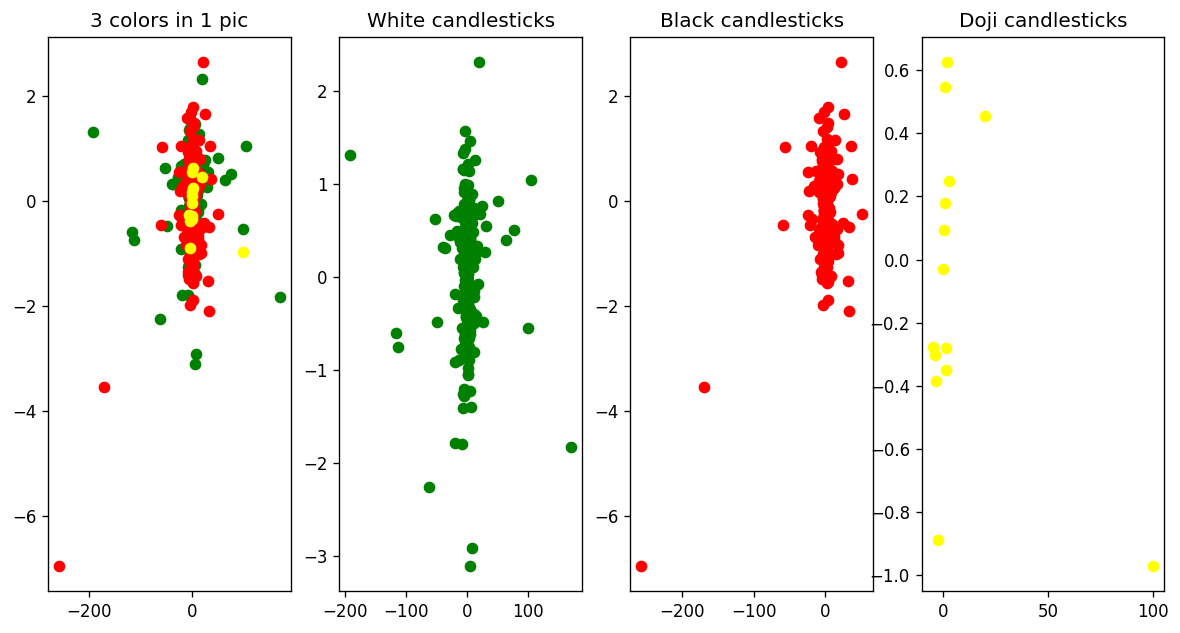

In [45]:
plt.subplot(1, 4, 1)
plt.title("3 colors in 1 pic")
plt.scatter(white_group['rate_overnight_14h'], white_group['rate_overnight_hl'], c='green')
plt.scatter(black_group['rate_overnight_14h'], black_group['rate_overnight_hl'], c='red')
plt.scatter(doji_group['rate_overnight_14h'], doji_group['rate_overnight_hl'], c='yellow')
plt.subplot(1, 4, 2)
plt.title("White candlesticks")
plt.scatter(white_group['rate_overnight_14h'], white_group['rate_overnight_hl'], c='green')
plt.subplot(1, 4, 3)
plt.title("Black candlesticks")
plt.scatter(black_group['rate_overnight_14h'], black_group['rate_overnight_hl'], c='red')
plt.subplot(1, 4, 4)
plt.title("Doji candlesticks")
plt.scatter(doji_group['rate_overnight_14h'], doji_group['rate_overnight_hl'], c='yellow')

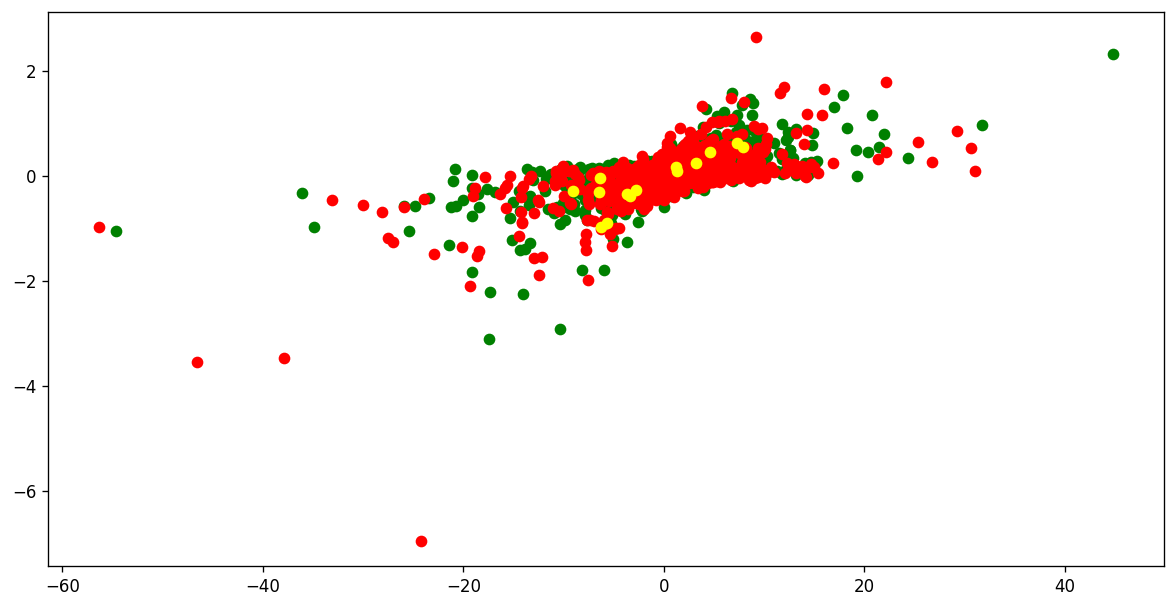

In [50]:
plt.scatter(white_group['rate_EMA_9hClose'], white_group['rate_overnight_hl'], c='green')
plt.scatter(black_group['rate_EMA_9hClose'], black_group['rate_overnight_hl'], c='red')
plt.scatter(doji_group['rate_EMA_9hClose'], doji_group['rate_overnight_hl'], c='yellow')

### Regplot

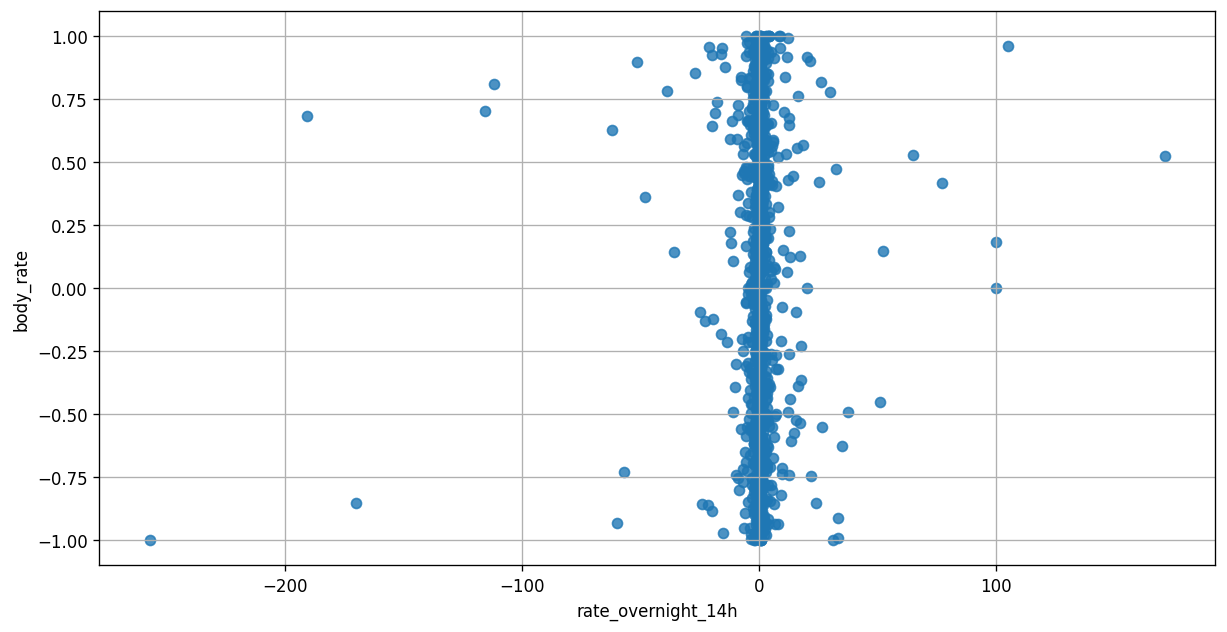

In [46]:
sns.regplot(x=day_data['rate_overnight_14h'], y=day_data['body_rate'])
plt.grid(True)

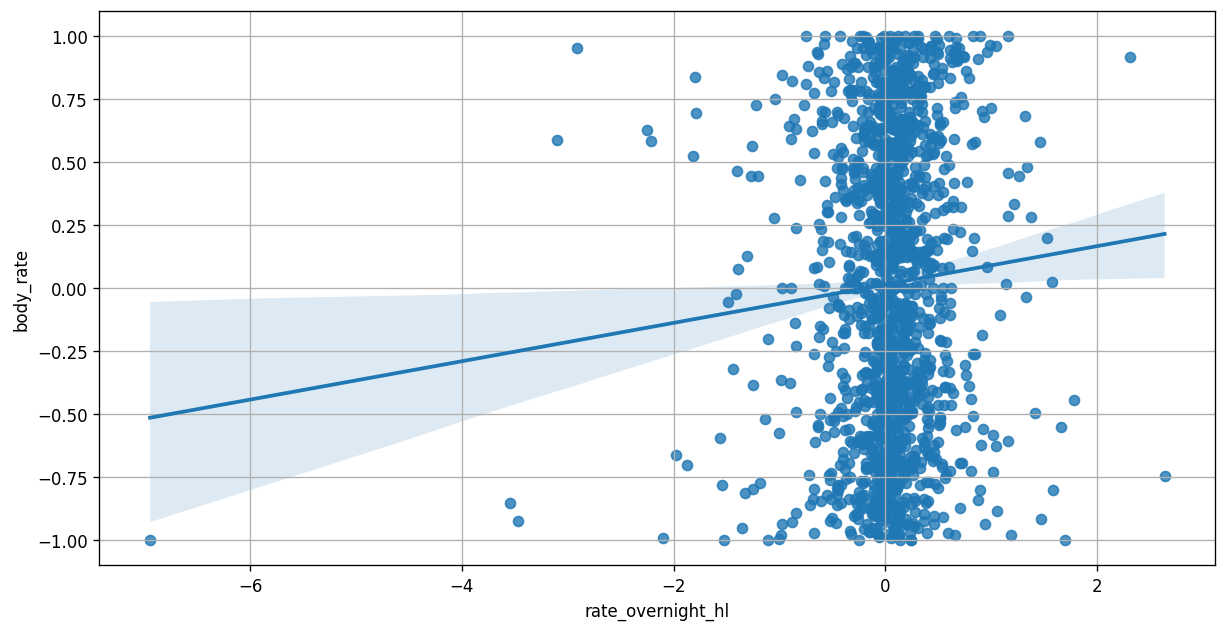

In [47]:
sns.regplot(x=day_data['rate_overnight_hl'], y=day_data['body_rate'])
plt.grid(True)

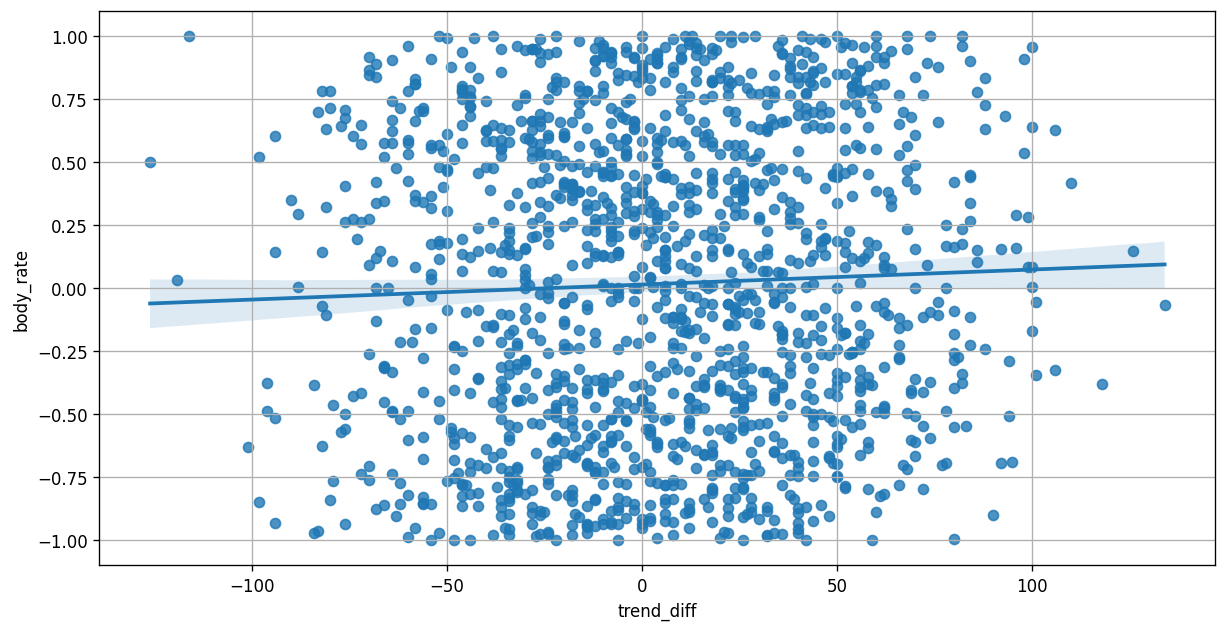

In [48]:
sns.regplot(x=day_data['trend_diff'], y=day_data['body_rate'])
plt.grid(True)

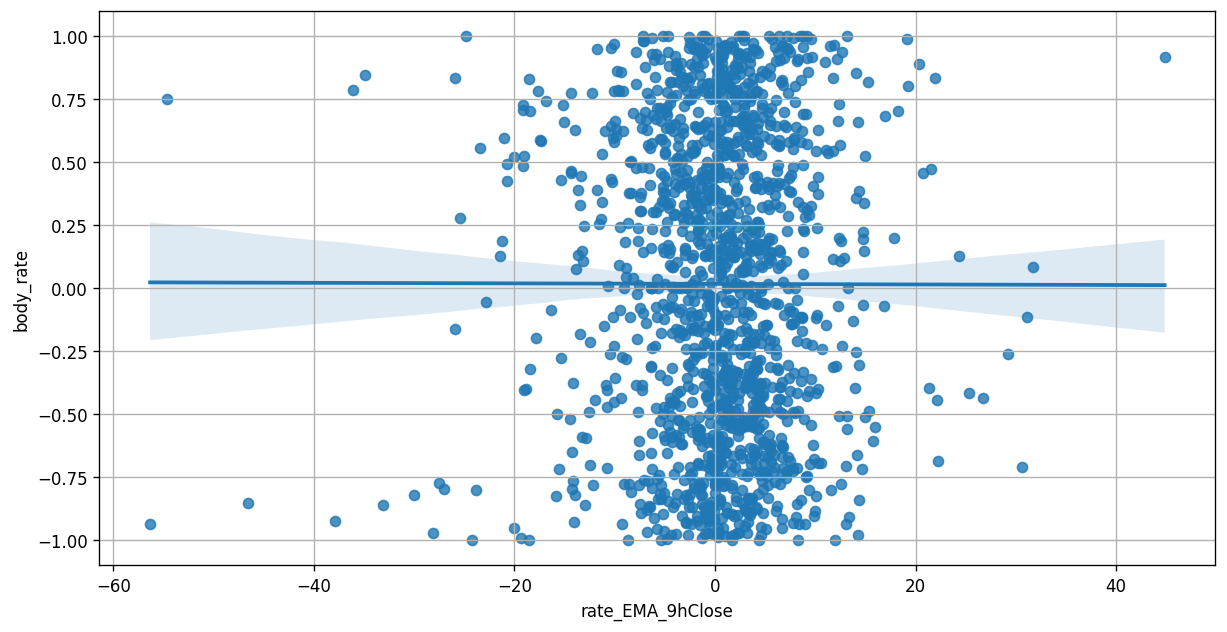

In [49]:
sns.regplot(x=day_data['rate_EMA_9hClose'], y=day_data['body_rate'])
plt.grid(True)